In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

# Постановка задачи

Задача Римана для одномерной нестационарной системы уравнений Эйлера прелставлеяет собой задачу Коши для законов сохранения

\begin{equation}
\left . 
\begin{array}{c}
\mathbf{U}_t + \mathbf{F}(\mathbf{U})_x = 0, \\
\mathbf{U} = \left[\begin{array}{c}\rho \\ \rho u  \\E \end{array}\right], 
\mathbf{F} = \left[\begin{array}{c}\rho u \\ \rho u^2+p  \\ u(E+p) \end{array}\right],
\end{array}
\right\}
\end{equation}

с начальными условиями

\begin{equation}
\mathbf{U}(x,0)=\mathbf{U}^{(0)}(x) = 
\left \{ 
\begin{array}{c}
\mathbf{U}_L ~\textrm{если} ~x<0, \\
\mathbf{U}_R ~\textrm{если} ~x>0.
\end{array}
\right .
\end{equation}

При решении задачи Римана будем использовать вектор примитивных переменных $\mathbf{W} = (\rho, u, p)^T$ вместо консервативных переменных (вектор $\mathbf{U}$). Тогда начальные условия задаются в виде двух векторов $\mathbf{W}_L = (\rho_L, u_L, p_L)^T$ для области слева от $x=0$ и $\mathbf{W}_R = (\rho_R, u_R, p_R)^T$ для области справа от $x=0$, области разделены скачком в $x=0$. Нужно найти решение в области, обозначенной на рисунке как _Star Region_.

![Схема задачи Римана](./figures/star_region.png "Схема задачи Римана")

Система уравнений замыкается уравнением состояния

\begin{equation}
e = \frac{p}{(\gamma -1) \rho}
\end{equation}

# Уравнения для давления и скорости

Согласно Торо, значение давления в интересующей нас области это корень алгебраического уравнения:

\begin{equation}
f(p,\mathbf{W}_L,\mathbf{W}_R) \equiv f_L(p,\mathbf{W}_L) +f_R(p,\mathbf{W}_R) + \Delta u = 0, ~ \Delta u \equiv u_R - u_L,
\end{equation}

где функция $f_L$ задается соотношением

\begin{equation}
f_L(p,\mathbf{W}_L) = 
\left \{ 
\begin{array}{ll}
(p-p_L)\left[ \frac{A_L}{p+B_L} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_L ~(скачок),& \\
\frac{2a_L}{(\gamma-1)}\left[ \left(\frac{p}{p_L} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_L ~(разрежение),&
\end{array}
\right .
\end{equation}

функция $f_R$ задается соотношением

\begin{equation}
f_R(p,\mathbf{W}_R) = 
\left \{ 
\begin{array}{ll}
(p-p_R)\left[ \frac{A_R}{p+B_R} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_R ~(скачок),& \\
\frac{2a_R}{(\gamma-1)}\left[ \left(\frac{p}{p_R} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_R ~(разрежение),&
\end{array}
\right .
\end{equation}

а константы $A_L,~B_L,~A_R,~B_R$ задаются как

\begin{equation}
\left .
\begin{array}{ll}
A_L = \frac{2}{(\gamma+1)\rho_L},~B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
A_R = \frac{2}{(\gamma+1)\rho_R},~B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R.
\end{array}
\right \}
\end{equation}

Скорость вычисляется из соотношения
\begin{equation}
u_*=\frac{1}{2}(u_L+u_R) + \frac{1}{2}[f_R(p_*) - f_L(p_*)].
\end{equation}

In [2]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [3]:
def sound_speed(d,p):
    return (gamma*(p/d))**0.5

In [4]:
def calc_f(p,d_k,u_k,p_k):
    c_k = sound_speed(d_k,p_k)
    
    if p > p_k:
        A = g_p_1_over_2_inv/d_k
        B = g_m_1_over_g_p_1*p_k
        f = (p - p_k)*(A/(p + B))**0.5
        f_deriv = (A/(p + B))**0.5*(1 - 0.5*(p - p_k)/(p + B))
    else :
        f = g_m_1_over_2_inv*c_k*((p/p_k)**g_m_1_over_2g - 1)
        f_deriv = ((p/p_k)**(-g_p_1_over_2g))/(d_k*c_k)
    
    return f,f_deriv


In [5]:
def guess_p(W_l,W_r,label):
    c_l = sound_speed(W_l[0],W_l[2])
    c_r = sound_speed(W_r[0],W_r[2])

    
    W_aver = 0.5*(W_l+W_r)
    p_pv = W_aver[2] - 0.5*(W_r[1]-W_l[1])*W_aver[0]*0.5*(c_l+c_r)
    p_0 = max(tol,p_pv)
    
    if label == 'TR':
        return ((c_l + c_r - 0.5*g_m_1*(W_r[1] - W_l[1]))/
                ((c_l/W_l[2]**g_m_1_over_2g) + (c_r/W_r[2]**g_m_1_over_2g) ))**g_m_1_over_2g_inv
    
    elif label == 'PV':

        return p_0
    
    elif label == 'TS':
        A_k = lambda x : g_p_1_over_2_inv/x
        B_k = lambda x : g_m_1_over_g_p_1*x
        p_ts = ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5*W_l[2] + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5*W_r[2] \
                - (W_r[1]-W_l[1])) /\
        ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5 + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5)  
        return max(tol,p_ts)
    else:
        return W_aver[2]
        
        

In [6]:
def init(case):
    if case == 'sod':
        W_l = np.array([1, 0.75, 1])
        W_r = np.array([0.125, 0, 0.1])
        t = 0.25
    elif case == '123':
        W_l = np.array([1, -2, 0.4])
        W_r = np.array([1, 2, 0.4])
        t = 0.15
    elif case == 'left-woodward':
        W_l = np.array([1, 0, 1000])
        W_r = np.array([1, 0, 0.1])
        
        t = 0.012
    else : print('Unknown case!')
    return W_l, W_r, t

In [7]:
W_l,W_r,_ = init('sod')

In [8]:
def newton(p_init,W_l,W_r):
    p_new = 1000
    p_curr = p_init
    cha =abs( 2*(p_new - p_curr)/(p_new + p_curr))
    i= 0
    while cha > tol:
        
        f_l = calc_f(p_curr,*W_l)
        f_r = calc_f(p_curr,*W_r)
        p_new = p_curr - (f_l[0]+f_r[0]+W_r[1]-W_l[1])/(f_l[1]+f_r[1])
        
        cha = abs(2*(p_new - p_curr)/(p_new + p_curr))
        p_curr = p_new
        i = i+1
    u_new = 0.5*(W_l+W_r)[1] + 0.5*(calc_f(p_new,*W_r)[0] - calc_f(p_new,*W_l)[0])
    return p_new,u_new

In [9]:
def sample(W_l,c_l,W_r, c_r, p_m, u_m, s):
    """Returns d,u,p in sampled point according the shock and wave configuration"""
    d_l, u_l, p_l = W_l
    d_r, u_r, p_r = W_r
    if s<= u_m:
        #точка лежит слева от контактного разрыва
        if p_m <= p_l: #слева -- волна разрежения
            head_speed_l = u_l - c_l   #скорость головной характеристики волны разрежения
            
            if s<= head_speed_l: #точка лежит слева от волны -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:
                c_m_l = c_l*(p_m/p_l)**g_m_1_over_2g #скорость звука справа от левой волны
                tail_speed_l = u_m - c_m_l        #скорость замыкающей характеристики волны разрежения
                
                if s>=tail_speed_l:              #точка лежит между волной и контактным разрывом
                    
                    d = d_l*(p_m/p_l)**(1./gamma)
                    u = u_m
                    p = p_m
                
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv*(c_l+g_m_1_over_2*u_l+s)
                    c = u - s
                    d = d_l*(c/c_l)**g_m_1_over_2_inv
                    p = p_l*(c/c_l)**g_m_1_over_2g_inv
        
        else:       #слева -- скачок 
            shock_ratio = p_m/p_l
            s_l = u_l - c_l*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            
            if s<= s_l: #точка лежит слева от скачка -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:   #точка лежит между скачком и контактным разрывом
                
                d = d_l*(shock_ratio + (gamma-1)/(gamma+1))/((gamma-1)/(gamma+1)*shock_ratio +1.)
                u = u_m
                p = p_m
    #----------------------------------------------------------------------------------------------------
    else:              #точка лежит справа от контактного разрыва
        
        if p_m > p_r:   #справа -- скачок
            shock_ratio = p_m/p_r
            s_r = u_r + c_r*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            
            if s >= s_r: #точка лежит справа от скачка -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:   #точка лежит между скачком и контактным разрывом
                
                d = d_r*(shock_ratio + g_m_1_over_g_p_1)/(g_m_1_over_g_p_1*shock_ratio +1.)
                u = u_m
                p = p_m
        else:           #справа -- волна
            
            head_speed_r = u_r + c_r   #скорость головной характеристики волны разрежения
            
            if s >= head_speed_r: #точка лежит справа от волны -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:
                c_m_r = c_r*(p_m/p_r)**g_m_1_over_2g #скорость звука слева от правой волны
                tail_speed_r = u_m + c_m_r           #скорость замыкающей характеристики волны разрежения
                
                if s<=tail_speed_r:              #точка лежит между контактным разрывом и волной
                    
                    d = d_r*(p_m/p_r)**(1/gamma)
                    u = u_m
                    p = p_m
                
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv*(-c_r+g_m_1_over_2*u_r+s)
                    c = -u + s
                    d = d_r*(c/c_r)**g_m_1_over_2_inv
                    p = p_r*(c/c_r)**g_m_1_over_2g_inv
                
    return d,u,p

In [10]:
def get_S_max(W_l,c_l,W_r, c_r, p_m, u_m):
    d_l, u_l, p_l = W_l
    d_r, u_r, p_r = W_r
    S_l,S_r = 0,0
    if p_m <= p_l: #слева -- волна разрежения
        S_l = u_l - c_l
    else :
        shock_ratio = p_m/p_l
        S_l = u_l - c_l*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5
    if p_m > p_r:
        shock_ratio = p_m/p_r
        S_r = u_r + c_r*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 
    else:
        S_r = u_r + c_r
        
    S_max = max(abs(S_l),abs(S_r))
    return S_max

In [11]:
N_points = 101
x = np.linspace(0,1,N_points)
decay_pos = 0.3
W_correct= np.zeros((N_points,3))

In [12]:
W_l,W_r,t = init('sod')
p_init = guess_p(W_l,W_r,'TR')
p_m, u_m = newton(p_init,W_l,W_r)


In [13]:
c_l = sound_speed(W_l[0],W_l[2])
c_r = sound_speed(W_r[0],W_r[2])
for i,x_ in enumerate(x):
    s = (x_ - decay_pos)/t
    W_correct[i] = np.asarray(sample(W_l,c_l,W_r, c_r, p_m, u_m, s))

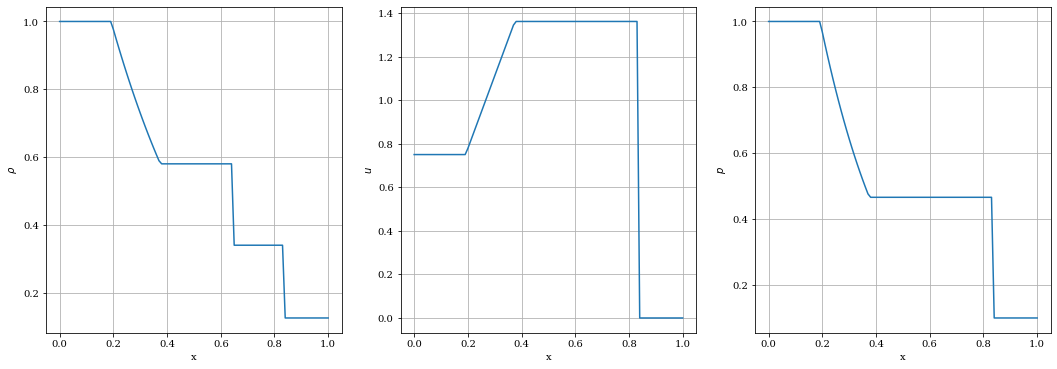

In [14]:

#pyplot.figure(figsize=(,6))
fig,axs = pyplot.subplots(1,3,figsize=(18,6))
for ax,W_,y_label in zip(axs,W_correct.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_)
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.grid()

In [15]:
%store W_correct

Stored 'W_correct' (ndarray)


In [41]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = g_m_1*(U[2] - 0.5*U[1]**2/U[0])
    return W

In [42]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = 0.5*W[1]**2*W[0]+W[2]/ g_m_1
    return U


In [43]:
def flux(W):
    F = np.zeros_like(W)
    F[0] = W[1]*W[0]
    F[1] = W[1]**2*W[0] + W[2]
    F[2] = W[1]*(0.5*W[1]**2*W[0]+W[2]/ g_m_1 + W[2])
    return F

In [44]:
%store flux

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.



In [45]:

dx = 1./(N_points - 1)
sigma = 0.9



W = np.zeros((N_points,3))
fluxes = np.zeros((N_points - 1,3))
U = np.zeros_like(W) 

In [46]:
W[np.where(x<decay_pos),:] = W_l
W[np.where(x>=decay_pos),:] = W_r

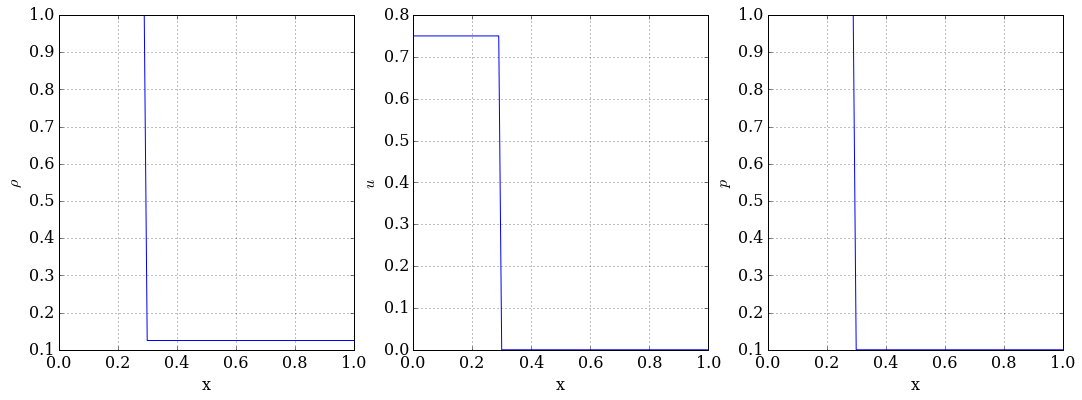

In [47]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6))
for ax,W_,y_label in zip(axs,W.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_)
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    
    ax.grid()

In [48]:
t_ = 0
#dt = 0.0002
U_n = np.copy(U)
while t_<t:
    U = W_to_U(W.T).T
    big_values = np.zeros((N_points - 1,3))
    speeds = np.zeros(N_points - 1)
    for i,x_ in enumerate(x[:-1]):
        p_init = guess_p(W[i],W[i+1],'TR')
        p_m, u_m = newton(p_init,W[i],W[i+1])
        c_l = sound_speed(W[i][0],W[i][2])
        c_r = sound_speed(W[i+1][0],W[i+1][2])
        s = 0
        big_values[i] = np.asarray(sample(W[i],c_l,W[i+1], c_r, p_m, u_m, s))
        speeds[i] = get_S_max(W[i],c_l,W[i+1], c_r, p_m, u_m)

    fluxes = flux(big_values.T).T
    dt = sigma*dx/max(speeds)
    U_n[1:-1,:] = U[1:-1,:] + dt/dx*(fluxes[:-1,:]-fluxes[1:,:]) 
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    W = U_to_W(U_n.T).T
    t_=t_+dt

In [49]:
W_g = np.copy(W)
%store W_g

Stored 'W_g' (ndarray)


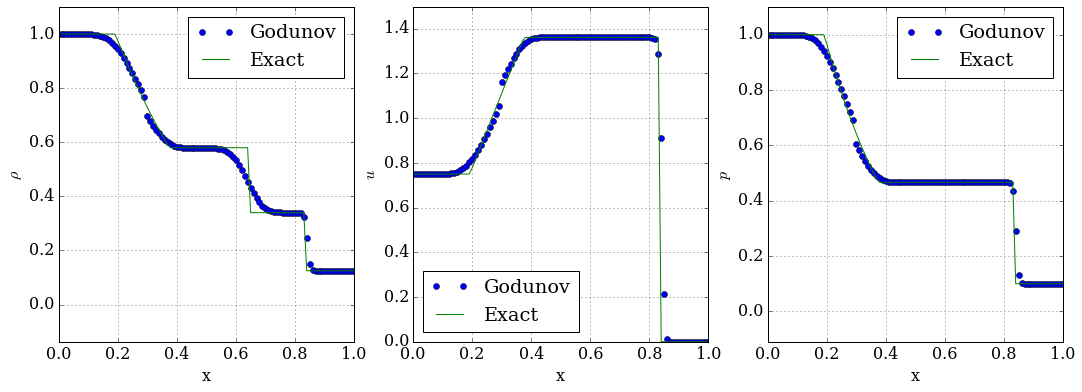

In [50]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6))
for ax,W_,W_c,y_label in zip(axs,W.T,W_correct.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_,'o',label='Godunov')
    ax.plot(x,W_c,label='Exact')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.set_ylim(-1.1*abs(min(W_c)),1.1*max(W_c))
    ax.legend(loc='best')
    ax.grid()
    

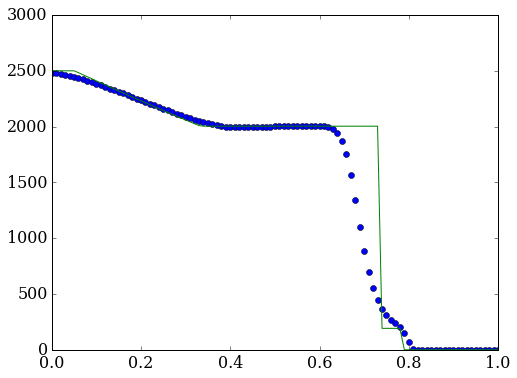

In [133]:
pyplot.figure(figsize=(8,6))
e = W[:,2]/W[:,0]/ g_m_1
e_ex = W_correct[:,2]/W_correct[:,0]/ g_m_1
pyplot.plot(x,e,'o',label='Godunov')
pyplot.plot(x,e_ex,'-',label='Exact')

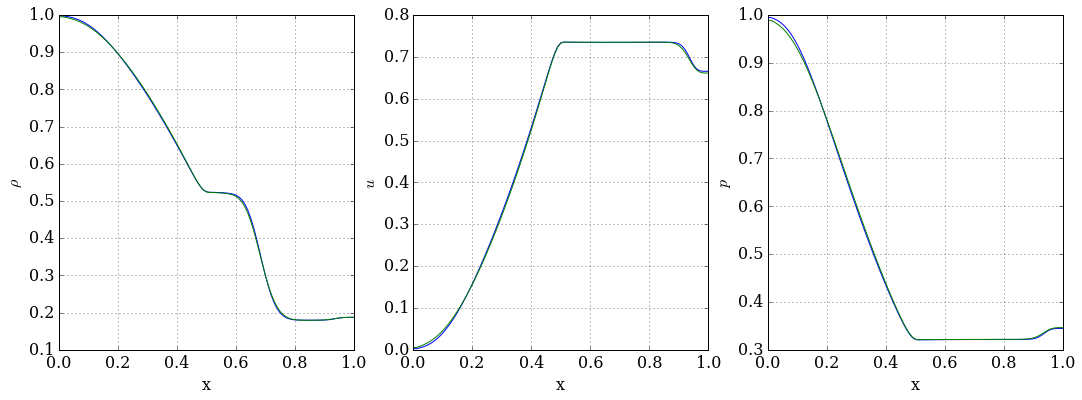

In [121]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6))
for ax,W_,W_c,y_label in zip(axs,W.T,W_small.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_,label='Exact')
    ax.plot(x,W_c,label='Godunov')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    #ax.legend()
    ax.grid()

In [131]:
a = np.array([[1,2,3],[2,5,6]])
b = a.T


In [135]:
a[0] = np.array([0,9,8])


In [136]:
b

array([[0, 2],
       [9, 5],
       [8, 6]])